In [1]:
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
dir0 = os.path.dirname(dir1)
if not dir1 in sys.path: sys.path.append(dir0)

In [2]:
from brio.utils.Preprocessing import Preprocessing
from sklearn.model_selection import train_test_split
from pickle import dump, load
import pandas as pd
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from functools import reduce
from itertools import compress

In [3]:
from brio.bias.FreqVsFreqBiasDetector import FreqVsFreqBiasDetector, BiasDetector
from brio.risk.HazardFromBiasDetectionCalculator import HazardFromBiasDetectionCalculator
from brio.risk.RiskCalculator import RiskCalculator

In [4]:
model_1 = pd.read_csv("./data/processed_model01.csv")
model_2 = pd.read_csv("./data/processed_model02.csv")
model_3 = pd.read_csv("./data/processed_model03.csv")
model_4 = pd.read_csv("./data/processed_model04.csv")
model_5 = pd.read_csv("./data/processed_model05.csv")

datasets = [model_1, model_2, model_3, model_4, model_5]
names = ["model_1", "model_2", "model_3", "model_4", "model_5"]

for df in datasets:
    df.rename(columns={"savings/bonds": "savings_bonds"}, inplace=True)

datasets_dict = {
    "model_1": model_1,
    "model_2": model_2,
    "model_3": model_3,
    "model_4": model_4,
    "model_5": model_5
}

In [5]:
sensitive_list = ['foreign_worker', 'personal_status_and_sex', 'age_group']
threshold=0.15
mode = 'group'
distance="TVD"
A1='high'
min_obs_per_group=30
aggregating_function=max

bd = FreqVsFreqBiasDetector(A1=A1, 
                            distance=distance, 
                            aggregating_function=aggregating_function)

hc = HazardFromBiasDetectionCalculator()

#business_list_by_model = {"model_1": ['status', 'duration', 'credit_history'],
#                          "model_2": ['status', 'duration', 'credit_history'],
#                          "model_3": ['status', 'property', 'credit_history'],
#                          "model_4": ['status', 'duration', 'credit_history'],
#                          "model_5": ['credit_history', 'number_of_credits', 'employment_duration']                         
#                         }

business_list_by_model = {"model_1": ['status', 'duration', 'credit_history', 'savings_bonds'],
                          "model_2": ['status', 'duration', 'credit_history', 'savings_bonds'],
                          "model_3": ['status', 'property', 'credit_history', 'savings_bonds'],
                          "model_4": ['status', 'duration', 'credit_history', 'savings_bonds'],
                          "model_5": ['credit_history', 'number_of_credits', 'employment_duration', 'other_debtors']                         
                         }

## Risk Path con valori percentuali

In [6]:
#path = {"step_1": [False, False, False],
#        "step_2": [True, False, False],
#        "step_3": [True, True, False],
#        "step_4": [True, True, True]}

path = {"step_1": [False, False, False, False],
        "step_2": [True, False, False, False],
        "step_3": [True, True, False, False],
        "step_4": [True, True, True, False],
        "step_5": [True, True, True, True]}

In [7]:
results_path_percentage = {}
for model in names:
    print(model)
    
    results_path_percentage[model] = {}

    conditioning_variables = business_list_by_model[model]
    print(conditioning_variables)
    
    for path_name, path_rules in path.items():

        path_variables = list(compress(conditioning_variables, path_rules))
        
        model_hazards_for_a_path = []
        for sensitive in sensitive_list:
            bias = bd.compare_root_variable_groups(
                    dataframe=datasets_dict[model],
                    target_variable='predicted_label',
                    root_variable=sensitive,
                    threshold=threshold
                )  

            if len(path_variables) > 0:
                bias_conditioned = bd.compare_root_variable_conditioned_groups(
                        dataframe=datasets_dict[model],
                        target_variable='predicted_label',
                        conditioning_variables=path_variables,
                        root_variable=sensitive,
                        threshold=threshold,
                        min_obs_per_group=min_obs_per_group
                    )
            else:
                bias_conditioned = None


            hazard = hc.compute_hazard_from_freqvsfreq_or_freqvsref(
                    overall_result=bias,
                    conditioned_results=bias_conditioned,
                    tot_observations=datasets_dict[model].shape[0],
                    conditioning_variables=business_list_by_model[model],
                    weight_logic=mode
                )
            
            model_hazards_for_a_path.append(hazard[0]/hazard[-1]) #just take the overall hazard and divides by max
            
        path_results_for_a_model = np.mean(model_hazards_for_a_path)
            
        results_path_percentage[model][path_name] = path_results_for_a_model   

model_1
['status', 'duration', 'credit_history', 'savings_bonds']
model_2
['status', 'duration', 'credit_history', 'savings_bonds']
model_3
['status', 'property', 'credit_history', 'savings_bonds']
model_4
['status', 'duration', 'credit_history', 'savings_bonds']
model_5
['credit_history', 'number_of_credits', 'employment_duration', 'other_debtors']


In [8]:
pd.DataFrame(results_path_percentage)

,model_1,model_2,model_3,model_4,model_5
step_1,1.000000,1.000000,0.666667,0.666667,0.333333
step_2,0.694451,0.694451,0.672949,0.584154,0.317007
step_3,0.768001,0.768001,0.776849,0.627976,0.418385
step_4,0.756760,0.756760,0.779942,0.644730,0.607803
step_5,0.741864,0.741864,0.793659,0.641232,0.644018


<AxesSubplot:>

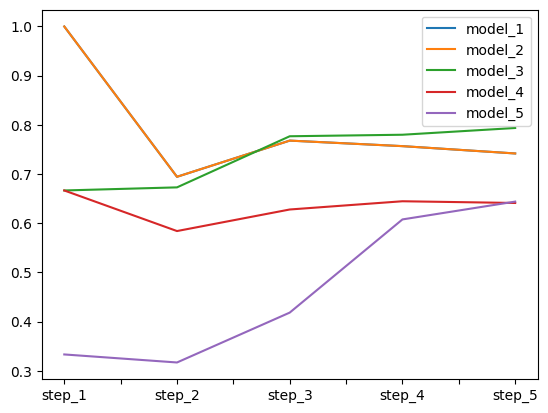

In [9]:
pd.DataFrame(results_path_percentage).plot()

## Risk Path con valori assoluti

In [10]:
#path = {"step_1": [False, False, False],
#        "step_2": [True, False, False],
#        "step_3": [True, True, False],
#        "step_4": [True, True, True]}

path = {"step_1": [False, False, False, False],
        "step_2": [True, False, False, False],
        "step_3": [True, True, False, False],
        "step_4": [True, True, True, False],
        "step_5": [True, True, True, True]}

In [11]:
results_path_absolute = {}
for model in names:
    print(model)
    
    results_path_absolute[model] = {}

    conditioning_variables = business_list_by_model[model]
    print(conditioning_variables)
    
    for path_name, path_rules in path.items():

        path_variables = list(compress(conditioning_variables, path_rules))
        
        model_hazards_for_a_path = []
        for sensitive in sensitive_list:
            bias = bd.compare_root_variable_groups(
                    dataframe=datasets_dict[model],
                    target_variable='predicted_label',
                    root_variable=sensitive,
                    threshold=threshold
                )  

            if len(path_variables) > 0:
                bias_conditioned = bd.compare_root_variable_conditioned_groups(
                        dataframe=datasets_dict[model],
                        target_variable='predicted_label',
                        conditioning_variables=path_variables,
                        root_variable=sensitive,
                        threshold=threshold,
                        min_obs_per_group=min_obs_per_group
                    )
            else:
                bias_conditioned = None


            hazard = hc.compute_hazard_from_freqvsfreq_or_freqvsref(
                    overall_result=bias,
                    conditioned_results=bias_conditioned,
                    tot_observations=datasets_dict[model].shape[0],
                    conditioning_variables=business_list_by_model[model],
                    weight_logic=mode
                )
            
            model_hazards_for_a_path.append(hazard[0]) #just take the overall hazard and divides by max
            
        path_results_for_a_model = np.mean(model_hazards_for_a_path)
            
        results_path_absolute[model][path_name] = path_results_for_a_model   

model_1
['status', 'duration', 'credit_history', 'savings_bonds']
model_2
['status', 'duration', 'credit_history', 'savings_bonds']
model_3
['status', 'property', 'credit_history', 'savings_bonds']
model_4
['status', 'duration', 'credit_history', 'savings_bonds']
model_5
['credit_history', 'number_of_credits', 'employment_duration', 'other_debtors']


In [12]:
pd.DataFrame(results_path_absolute)

,model_1,model_2,model_3,model_4,model_5
step_1,0.150128,0.150128,0.149815,0.124754,0.018469
step_2,0.077657,0.077657,0.078227,0.069156,0.031173
step_3,0.064248,0.064248,0.067399,0.055374,0.041646
step_4,0.061510,0.061510,0.058631,0.053250,0.042407
step_5,0.054042,0.054042,0.054527,0.047311,0.045731


<AxesSubplot:>

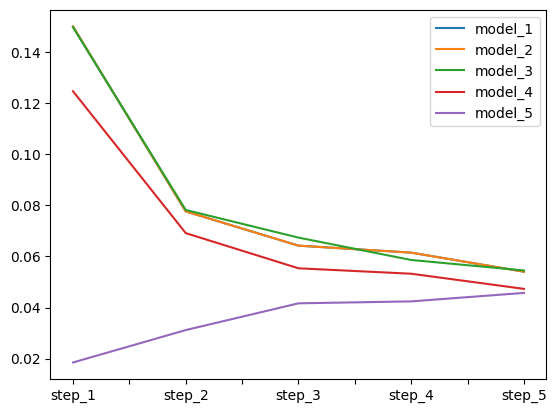

In [13]:
pd.DataFrame(results_path_absolute).plot()

## Threshold analysis

In [14]:
results_threshold_percentage = {}
for model in names:
    print(model)
    
    thresholds = np.arange(0.05, 1, 0.05)
    
    calibration_results_for_a_model = []
    for t in thresholds:
        print("Threshold: ", t)

        path_variables = list(compress(conditioning_variables, path_rules))
        
        model_hazards_for_a_threshold = []
        for sensitive in sensitive_list:
            bias = bd.compare_root_variable_groups(
                    dataframe=datasets_dict[model],
                    target_variable='predicted_label',
                    root_variable=sensitive,
                    threshold=t
                )  

            bias_conditioned = bd.compare_root_variable_conditioned_groups(
                    dataframe=datasets_dict[model],
                    target_variable='predicted_label',
                    conditioning_variables=business_list_by_model[model],
                    root_variable=sensitive,
                    threshold=t,
                    min_obs_per_group=min_obs_per_group
                )


            hazard = hc.compute_hazard_from_freqvsfreq_or_freqvsref(
                    overall_result=bias,
                    conditioned_results=bias_conditioned,
                    tot_observations=datasets_dict[model].shape[0],
                    conditioning_variables=business_list_by_model[model],
                    weight_logic=mode
                )
            
            model_hazards_for_a_threshold.append(hazard[0]/hazard[-1]) #just take the overall hazard and divides by max

        calibration_results_for_a_model.append(np.nanmean(model_hazards_for_a_threshold))
            
    results_threshold_percentage[model] = calibration_results_for_a_model   

model_1
Threshold:  0.05
Threshold:  0.1
Threshold:  0.15000000000000002
Threshold:  0.2
Threshold:  0.25
Threshold:  0.3
Threshold:  0.35000000000000003
Threshold:  0.4
Threshold:  0.45
Threshold:  0.5
Threshold:  0.55
Threshold:  0.6000000000000001
Threshold:  0.6500000000000001
Threshold:  0.7000000000000001
Threshold:  0.7500000000000001
Threshold:  0.8
Threshold:  0.8500000000000001
Threshold:  0.9000000000000001
Threshold:  0.9500000000000001
model_2
Threshold:  0.05
Threshold:  0.1
Threshold:  0.15000000000000002
Threshold:  0.2
Threshold:  0.25
Threshold:  0.3
Threshold:  0.35000000000000003
Threshold:  0.4
Threshold:  0.45
Threshold:  0.5
Threshold:  0.55
Threshold:  0.6000000000000001
Threshold:  0.6500000000000001
Threshold:  0.7000000000000001
Threshold:  0.7500000000000001
Threshold:  0.8
Threshold:  0.8500000000000001
Threshold:  0.9000000000000001
Threshold:  0.9500000000000001
model_3
Threshold:  0.05
Threshold:  0.1
Threshold:  0.15000000000000002
Threshold:  0.2
Thres

In [15]:
pd.DataFrame(results_threshold_percentage)

,model_1,model_2,model_3,model_4,model_5
0,0.925671,0.925671,0.987208,0.923173,0.909888
1,0.863713,0.863713,0.946130,0.798008,0.811367
2,0.741864,0.741864,0.793659,0.641232,0.644018
3,0.572401,0.572401,0.632218,0.506906,0.478873
4,0.486359,0.486359,0.501363,0.395547,0.366390
5,0.392533,0.392533,0.384812,0.287968,0.274522
6,0.263173,0.263173,0.292337,0.188419,0.210978
7,0.193512,0.193512,0.210106,0.144787,0.177703
8,0.142047,0.142047,0.171027,0.123472,0.139104
9,0.108932,0.108932,0.131483,0.094612,0.115225


<AxesSubplot:>

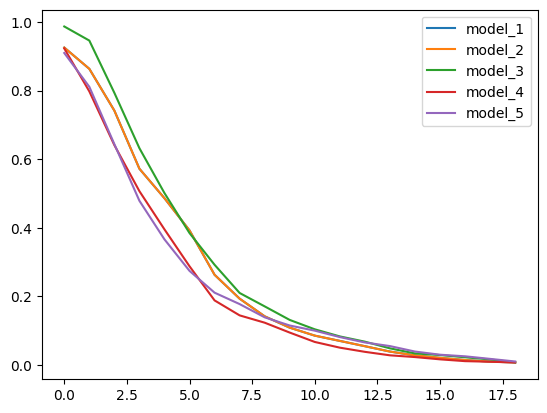

In [16]:
pd.DataFrame(results_threshold_percentage).plot()

## Threshold analysis with absolute values

In [17]:
results_threshold_absolute = {}
for model in names:
    print(model)
    
    thresholds = np.arange(0.05, 1, 0.05)
    
    calibration_results_for_a_model = []
    for t in thresholds:
        print("Threshold: ", t)

        path_variables = list(compress(conditioning_variables, path_rules))
        
        model_hazards_for_a_threshold = []
        for sensitive in sensitive_list:
            bias = bd.compare_root_variable_groups(
                    dataframe=datasets_dict[model],
                    target_variable='predicted_label',
                    root_variable=sensitive,
                    threshold=t
                )  

            bias_conditioned = bd.compare_root_variable_conditioned_groups(
                    dataframe=datasets_dict[model],
                    target_variable='predicted_label',
                    conditioning_variables=business_list_by_model[model],
                    root_variable=sensitive,
                    threshold=t,
                    min_obs_per_group=min_obs_per_group
                )


            hazard = hc.compute_hazard_from_freqvsfreq_or_freqvsref(
                    overall_result=bias,
                    conditioned_results=bias_conditioned,
                    tot_observations=datasets_dict[model].shape[0],
                    conditioning_variables=business_list_by_model[model],
                    weight_logic=mode
                )
            
            model_hazards_for_a_threshold.append(hazard[0]) #just take the overall hazard

        calibration_results_for_a_model.append(np.nanmean(model_hazards_for_a_threshold))
            
    results_threshold_absolute[model] = calibration_results_for_a_model   

model_1
Threshold:  0.05
Threshold:  0.1
Threshold:  0.15000000000000002
Threshold:  0.2
Threshold:  0.25
Threshold:  0.3
Threshold:  0.35000000000000003
Threshold:  0.4
Threshold:  0.45
Threshold:  0.5
Threshold:  0.55
Threshold:  0.6000000000000001
Threshold:  0.6500000000000001
Threshold:  0.7000000000000001
Threshold:  0.7500000000000001
Threshold:  0.8
Threshold:  0.8500000000000001
Threshold:  0.9000000000000001
Threshold:  0.9500000000000001
model_2
Threshold:  0.05
Threshold:  0.1
Threshold:  0.15000000000000002
Threshold:  0.2
Threshold:  0.25
Threshold:  0.3
Threshold:  0.35000000000000003
Threshold:  0.4
Threshold:  0.45
Threshold:  0.5
Threshold:  0.55
Threshold:  0.6000000000000001
Threshold:  0.6500000000000001
Threshold:  0.7000000000000001
Threshold:  0.7500000000000001
Threshold:  0.8
Threshold:  0.8500000000000001
Threshold:  0.9000000000000001
Threshold:  0.9500000000000001
model_3
Threshold:  0.05
Threshold:  0.1
Threshold:  0.15000000000000002
Threshold:  0.2
Thres

In [18]:
pd.DataFrame(results_threshold_absolute)

,model_1,model_2,model_3,model_4,model_5
0,0.053037,0.053037,0.055837,0.049162,0.050954
1,0.058924,0.058924,0.061078,0.050441,0.051397
2,0.054042,0.054042,0.054527,0.047311,0.045731
3,0.048232,0.048232,0.047729,0.040026,0.039379
4,0.042192,0.042192,0.041725,0.033834,0.033965
5,0.033034,0.033034,0.034550,0.026090,0.028395
6,0.026508,0.026508,0.028967,0.019743,0.024752
7,0.021726,0.021726,0.022995,0.017113,0.023072
8,0.017504,0.017504,0.020218,0.016007,0.019581
9,0.014863,0.014863,0.016543,0.013078,0.017577


<AxesSubplot:>

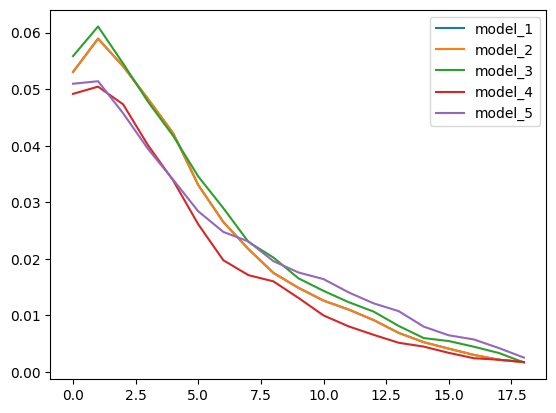

In [19]:
pd.DataFrame(results_threshold_absolute).plot()